In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

In [3]:
from src.bill_passage.postmodeling.score_calibration_functions import get_passage_prob_model_score_buckets

In [4]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

In [5]:
# exp_hash = 'aa36a41222408534233ebd20b7adca54'
# model_group = 375

# exp_hash = '08cbc4fc106da637694bea74a0395f8a'
# model_group = 472

# exp_hash = 'f08d1c3b0dc1e385cc88f59a28c44b30'
# model_group = 460

## Smaller RF
# exp_hash = '53ed7b325546f0213e581f0f041a2fc8'
# model_group = 424


# LR
# exp_hash = 'f8b82354cd664458c6f1a738aabb12b8'
# model_group = 517


# exp_hash='170870efbfa049eff695a0423dfe5ea8'
# model_group=716

exp_hash = '5bf28511f823b995bb5f843574ba2282'

In [6]:
model_group = 751
label_timespan = '12month'

#### Models in group

In [51]:
q = """
    select 
        model_id,
        to_char(train_end_time, 'YYYY-MM-DD') as train_end_time_str,
        train_end_time
    from triage_metadata.experiment_models
        join triage_metadata.models using(model_hash) 
    where     model_group_id={model_group} and train_end_time > '2015-01-01'
    order by train_end_time
""".format(
    exp_hash=exp_hash,
    label_timespan=label_timespan,
    model_group=model_group
)

models = pd.read_sql(q, db_conn)

#### Score distributions

/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


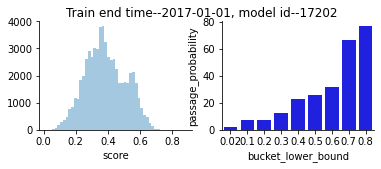

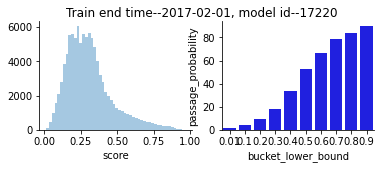

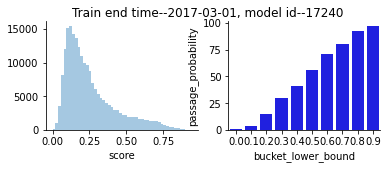

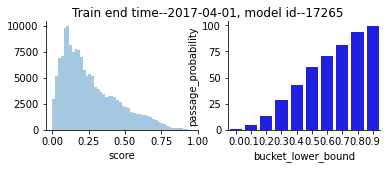

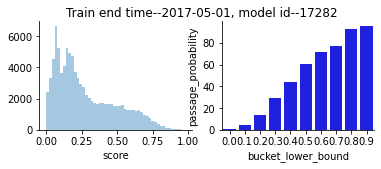

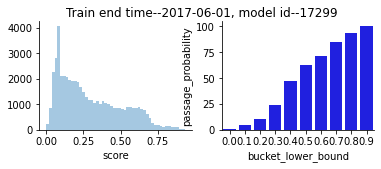

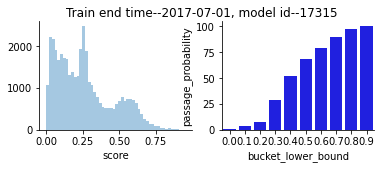

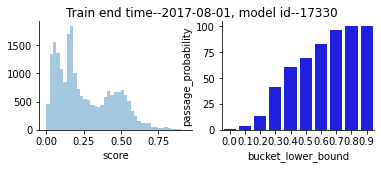

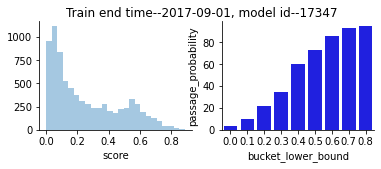

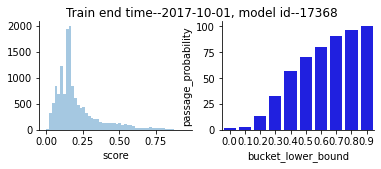

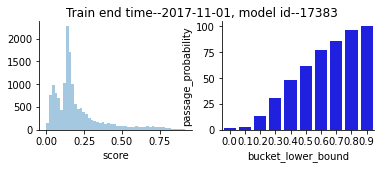

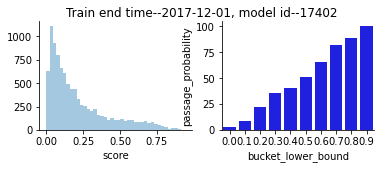

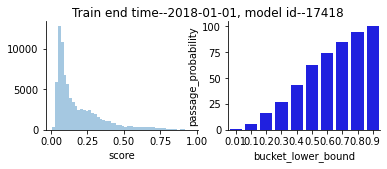

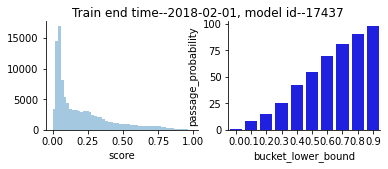

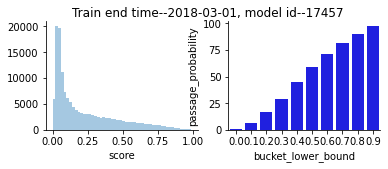

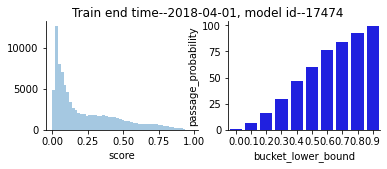

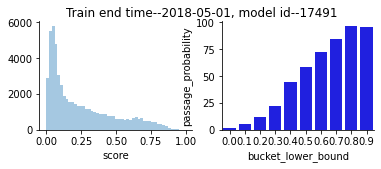

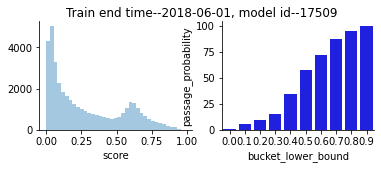

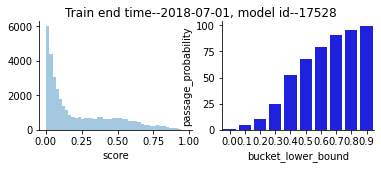

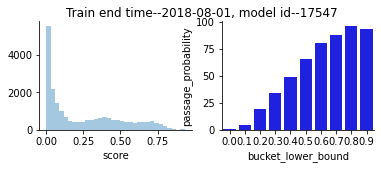

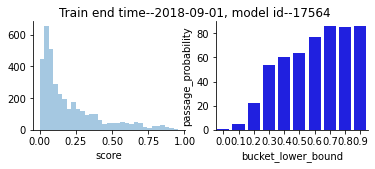

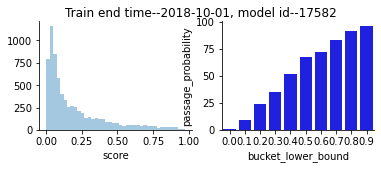

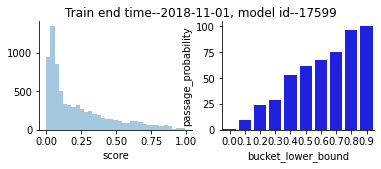

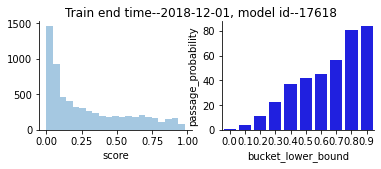

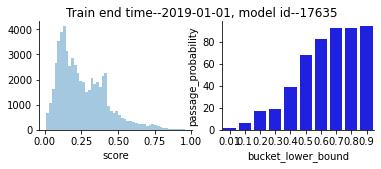

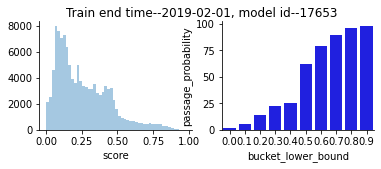

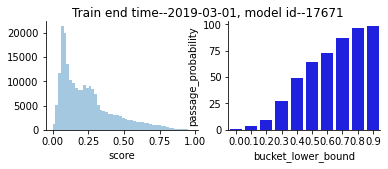

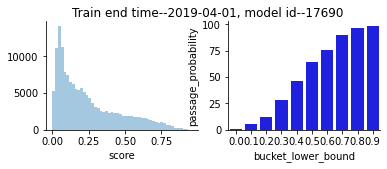

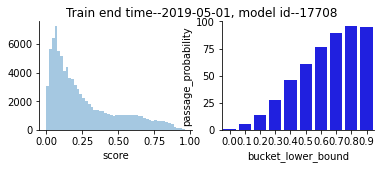

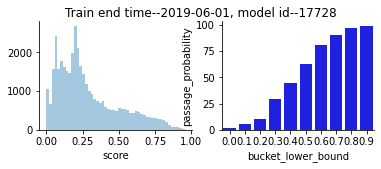

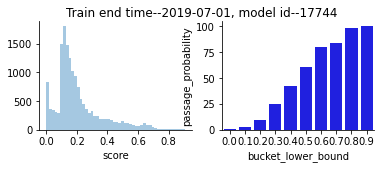

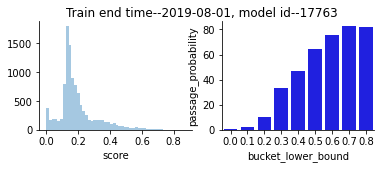

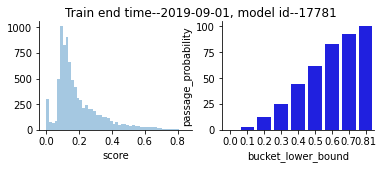

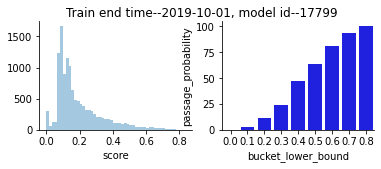

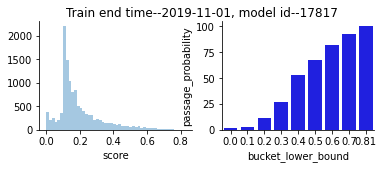

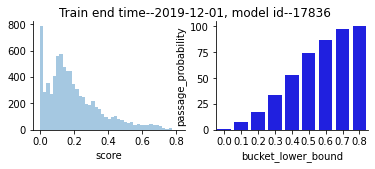

In [52]:
# fig.suptitle('Model group {}'.format(model_group))
query = """select * from test_results.predictions where model_id={} order by score desc"""
for index, row in models.iterrows():
    model_id = row['model_id']
    train_end_time = row['train_end_time_str']
    
    q = query.format(model_id)
    model_scores = pd.read_sql(q, db_conn)
    
    score_buckets = get_passage_prob_model_score_buckets(
        db_conn, model_id, num_buckets=10
    )
    fig, axes = plt.subplots(1, 2, figsize=(6, 2))
    fig.suptitle('Train end time--{}, model id--{}'.format(train_end_time, model_id))
    sns.distplot(model_scores['score'], kde=False, ax=axes[0])
    sns.barplot(data=score_buckets, x='bucket_lower_bound', y='passage_probability', ax=axes[1], color='blue')
#     axes[1].legend(bbox_to_anchor=(1.05, 1))
    
    sns.despine()
#     plt.tight_layout()

    

In [13]:
# fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_title('Passage probability for score buckets -- Model id {}, train end time {}'.format(model_id, train_end_time))
# sns.distplot(model_scores['score'], kde=False)

In [14]:
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.barplot(data=score_buckets, x='bucket_lower_bound', y='passage_probability', hue='model_id')
# ax.set_title('Passage probability for score buckets -- Model id {}, train end time {}'.format(model_id, train_end_time))
# sns.despine()

#### Passage likelihoods

Here, we are trying to learn the lower bound probabilities for a passage category using the older time splits

In [14]:
# lower bound probabilities
categories = {
    'highly_likely': 0.90,
    'likely': 0.7,
    'somewhat_likely': 0.4,
    'unlikely': 0.1,
    'highly_unlikely': 0
}

In [15]:
thresholds = list()

for i, row in models.iterrows():
    model_id = row['model_id']
    train_end_time = row['train_end_time']
    
    q = query.format(model_id)
    scores = pd.read_sql(q, db_conn)

    ub = 1
    for cat, thresh in categories.items():
        d = dict()
        for lb in np.arange(ub, 0, -0.01):

            msk = (scores['score'] >= lb) & (scores['score'] < ub)
    #         print('samples above threshold -- ', len(scores[msk]))
    #         print('number of ones -- ', scores[msk]['label_value'].sum())
            passage_prob = scores[msk]['label_value'].sum()/len(scores[msk])

    #         print('start score {} with prob {}'.format(round(lb, 2), round(passage_prob, 2)))

            if passage_prob < thresh:
    #             print('Found threshold!')
                d['model_id'] = model_id
                d['train_end_time'] = train_end_time 
                d['category'] = cat
                d['score_lb'] = round(lb, 2)
                d['passage_prob'] = round(passage_prob, 2)
                thresholds.append(d)
                ub = lb
                break
    

/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [16]:
thresh_df = pd.DataFrame(thresholds)

In [17]:
thresh_df.head()

,category,model_id,passage_prob,score_lb,train_end_time
0,highly_likely,17202,0.67,0.85,2017-01-01
1,likely,17202,0.69,0.70,2017-01-01
2,somewhat_likely,17202,0.40,0.65,2017-01-01
3,highly_likely,17220,0.89,0.95,2017-02-01
4,likely,17220,0.69,0.55,2017-02-01


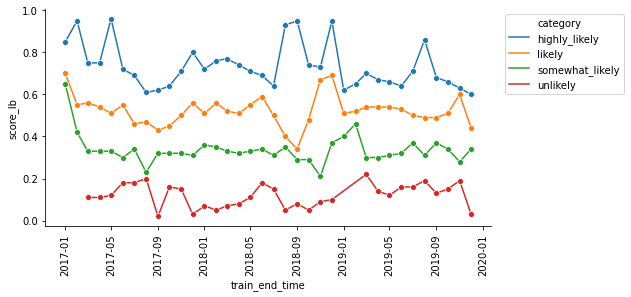

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

sns.lineplot(
    data=thresh_df,
    x='train_end_time',
    y='score_lb',
    hue='category',
    marker='o',
    ax=axes
)

sns.despine()
plt.legend(bbox_to_anchor=(1.02, 1))
t = plt.xticks(rotation=90)

**Now let's take the thresholds from the last available labels and use them for calibration**

In [19]:
q = """
    select 
        model_id,
        to_char(train_end_time, 'YYYY-MM-DD') as train_end_time_str,
        train_end_time::date,
        to_char(train_end_time - '{label_timespan}'::interval, 'YYYY-MM-DD') as last_available_date_str,
        (train_end_time - '{label_timespan}'::interval)::date as last_available_date
    from triage_metadata.experiment_models
        join triage_metadata.models using(model_hash) 
    where model_group_id={model_group} and train_end_time > '2015-01-01'
    order by train_end_time
""".format(
    exp_hash=exp_hash,
    label_timespan=label_timespan,
    model_group=model_group
)

models_reverse = pd.read_sql(q, db_conn) 

In [20]:
models_reverse.head()

,model_id,train_end_time_str,train_end_time,last_available_date_str,last_available_date
0,17202,2017-01-01,2017-01-01,2016-01-01,2016-01-01
1,17220,2017-02-01,2017-02-01,2016-02-01,2016-02-01
2,17240,2017-03-01,2017-03-01,2016-03-01,2016-03-01
3,17265,2017-04-01,2017-04-01,2016-04-01,2016-04-01
4,17282,2017-05-01,2017-05-01,2016-05-01,2016-05-01


In [21]:
last_known_thresholds = list()

for i, row in models_reverse.iterrows():
#     print(row)
    labels_available = row['last_available_date_str']
    model_id = row['model_id']
    train_end_time = row['train_end_time']
    
    for cat, thresh in categories.items():
        d = dict()
        d['model_id'] = model_id
        d['train_end_time'] = train_end_time
        d['category'] = cat
        
        msk = (thresh_df['train_end_time'] == labels_available) & (thresh_df['category'] == cat)
#         print(thresh_df[msk])
        if not thresh_df[msk].empty:
            d['score_lb'] = thresh_df[msk]['score_lb'].iloc[0]
            d['passage_prob'] = thresh_df[msk]['passage_prob'].iloc[0]

            last_known_thresholds.append(d)
# last_known_thresholds 

In [22]:
last_known_thresh_df = pd.DataFrame(last_known_thresholds)

In [23]:
last_known_thresh_df.head()

,category,model_id,passage_prob,score_lb,train_end_time
0,highly_likely,17418,0.67,0.85,2018-01-01
1,likely,17418,0.69,0.70,2018-01-01
2,somewhat_likely,17418,0.40,0.65,2018-01-01
3,highly_likely,17437,0.89,0.95,2018-02-01
4,likely,17437,0.69,0.55,2018-02-01


Text(0.5, 1.0, 'Using the thresholds from 12 months ago to determine the passage categories')

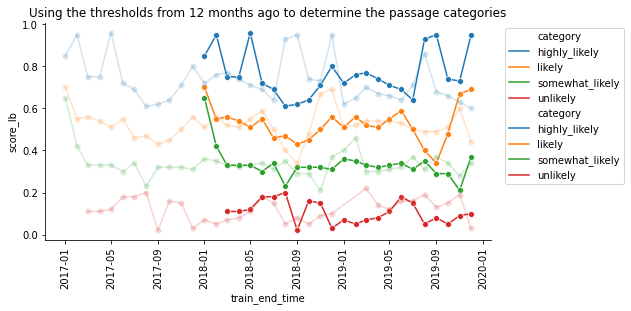

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

sns.lineplot(
    data=last_known_thresh_df,
    x='train_end_time',
    y='score_lb',
    hue='category',
    marker='o',
    ax=axes
)

sns.lineplot(
    data=thresh_df,
    x='train_end_time',
    y='score_lb',
    hue='category',
    marker='o',
    ax=axes,
    alpha=0.2
)

sns.despine()
plt.legend(bbox_to_anchor=(1.02, 1))
t = plt.xticks(rotation=90)
plt.title('Using the thresholds from 12 months ago to determine the passage categories')

##### Note

Earlier, I was eyeballing score distributions and setting score bands for each probability category, What if we use the average/median scores that we learned from history? 

In [25]:
lbs = thresh_df.groupby('category').median()['score_lb'].to_dict()
lbs

{'highly_likely': 0.71,
 'likely': 0.515,
 'somewhat_likely': 0.33,
 'unlikely': 0.12}

In [26]:
# so, our new buckets:

buckets_new = {
    'highly_likely': [0.71, 1.1],
    'likely': [0.515, 0.71],
    'somewhat_likely': [0.33, 0.515],
    'unlikely': [0.120, 0.33],
    'highly_unlikely': [0, 0.120]
}

#### Passage likelihood buckets

This was the old code where I used the eye-balled passage likliehood categories and the scores. 

In [299]:
# buckets = {
#     'will_not_pass': [0, 0.10],
#     'unlikely': [0.10, 0.30],
#     'somewhat_unlikely': [0.30, 0.50],
#     'somewhat_likely': [0.50, 0.70],
#     'very_likely': [0.70, 0.90],
#     'will_pass': [0.90, 1.1]
# }

# buckets = {
#     'will_not_pass': [0, 0.10],
#     'unlikely': [0.10, 0.40],
#     'somewhat_likely': [0.40, 0.80],
#     'highly_likely': [0.80, 1.1]
# }

buckets_last_used = {
    'will_not_pass': [0, 0.10],
    'unlikely': [0.10, 0.35],
    'could go either way': [0.35, 0.55],
    'likely': [0.55, 0.70],
    'very_likely': [0.70, 0.90],
    'will_pass': [0.90, 1.1]
}

In [27]:
buckets = buckets_new

In [28]:
q = """
    select 
        model_id,
        (sum(label_value)::float/count(*)) * 100 as passage_probability,
        count(*) as num_instances
    from test_results.predictions
    where model_id in {model_ids}
    and score >= {lower_lim_bucket}
    and score < {upper_lim_bucket}
    group by 1
"""

bucket_probabilities = pd.DataFrame()
for b, lim in buckets.items():    
    df = pd.read_sql(
        q.format(
            model_ids=tuple(models['model_id'].tolist()),
            lower_lim_bucket=lim[0],
            upper_lim_bucket=lim[1]
        ),
        db_conn
    )
    df['bucket_label'] = b
    df['lower_lim'] = lim[0]
    df['upper_lim'] = lim[1]
    
    bucket_probabilities = bucket_probabilities.append(df)
    

In [29]:
bucket_probabilities = bucket_probabilities.merge(models, on='model_id')

In [30]:
bucket_probabilities['num_instances'] = bucket_probabilities['num_instances'].astype(int)

#### Passage probability for the buckets over time

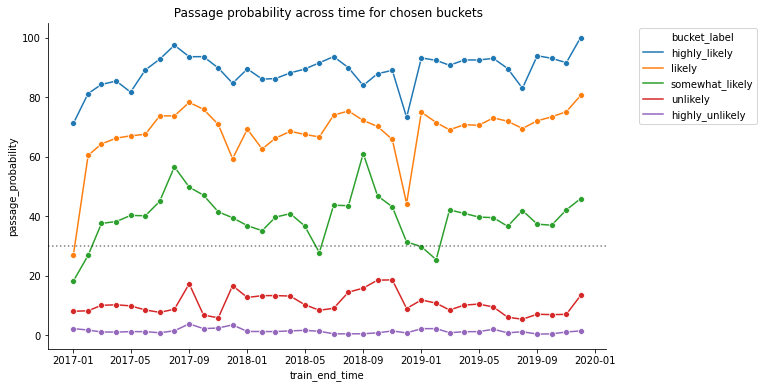

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.lineplot(
    data=bucket_probabilities,
    x='train_end_time',
    y='passage_probability',
    hue='bucket_label',
    marker='o',
    ax=ax
)
# g.set_xticklabels(labels=bucket_probabilities['train_end_time'].unique(), rotation=90)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.axhline(y=30, color='k', linestyle=':', alpha=0.5)
# t = ax.set_title(' Passage probability across time for chosen buckets \n (lower limit inclusive) \n \n {} \n'.format(buckets))
t = ax.set_title(' Passage probability across time for chosen buckets')

#### Mean probabilities across time for the buckets

In [32]:
from numpy import median, sum

Text(0, 0.5, 'mean passage probability over time')

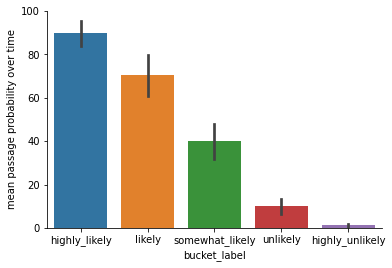

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(
    data=bucket_probabilities,
    x='bucket_label',
    y='passage_probability',
    ax=ax,
    ci='sd',
    estimator=median
)
sns.despine()
ax.set_ylabel('mean passage probability over time')

##### Number of instances that fall in each category

Text(0, 0.5, 'num instances in the bucket')

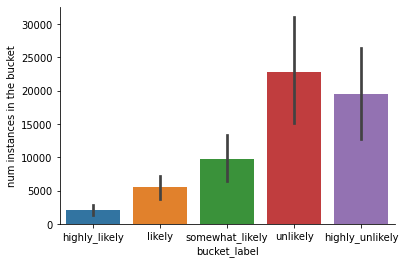

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    data=bucket_probabilities,
    x='bucket_label',
    y='num_instances',
    ax=ax,
#     ci='sd',
#     estimator=sum
)
sns.despine()
ax.set_ylabel('num instances in the bucket')

#### Number of instances in categories over time

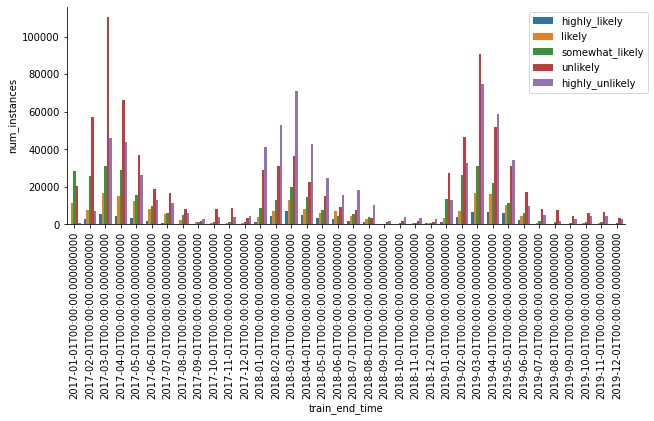

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=bucket_probabilities,
    x='train_end_time',
    y='num_instances',
    hue='bucket_label',
#     marker='o',
    ax=ax
)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1))
t=plt.xticks(rotation = 90)

#### cohort sizes

In [36]:
q = """
    select 
        model_id,
        count(*) as cohort_size
    from test_results.predictions
    where model_id in {model_ids}
    group by 1
""".format(
    model_ids=tuple(models['model_id'].tolist())
)

# merging to get the train_end_time
cohorts = pd.read_sql(q, db_conn).merge(models, on='model_id')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text major ticklabel objects>)

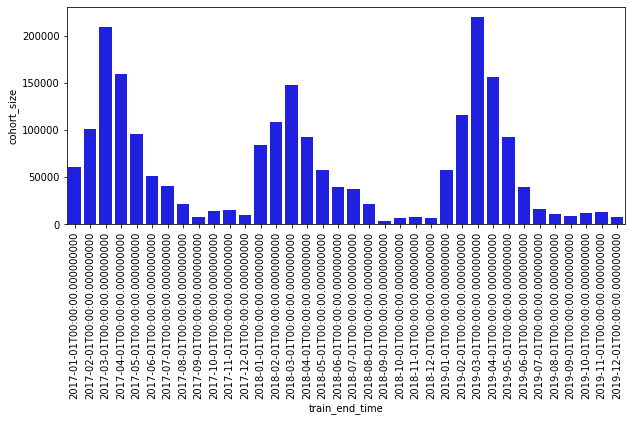

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=cohorts, x='train_end_time', y='cohort_size', color='blue')
plt.xticks(rotation = 90)

#### Across States

In [39]:
q = """
    select 
        c.model_id, 
        state,
        (sum(label_value)::float/count(*)) * 100 as passage_probability,
        count(*) as num_instances
    from clean.bills a join test_results.predictions c on a.bill_id=c.entity_id
    where model_id in {model_ids}
    and score >= {lower_lim_bucket}
    and score < {upper_lim_bucket}
    group by 1, 2
"""

In [40]:
state_bucket_probabilities = pd.DataFrame()
for b, lim in buckets.items():    
    df = pd.read_sql(
        q.format(
            model_ids=tuple(models['model_id'].tolist()),
            lower_lim_bucket=lim[0],
            upper_lim_bucket=lim[1]
        ),
        db_conn
    )
    df['bucket_label'] = b
    df['lower_lim'] = lim[0]
    df['upper_lim'] = lim[1]
    
    state_bucket_probabilities = state_bucket_probabilities.append(df)

In [41]:
state_bucket_probabilities = state_bucket_probabilities.merge(models, on='model_id')

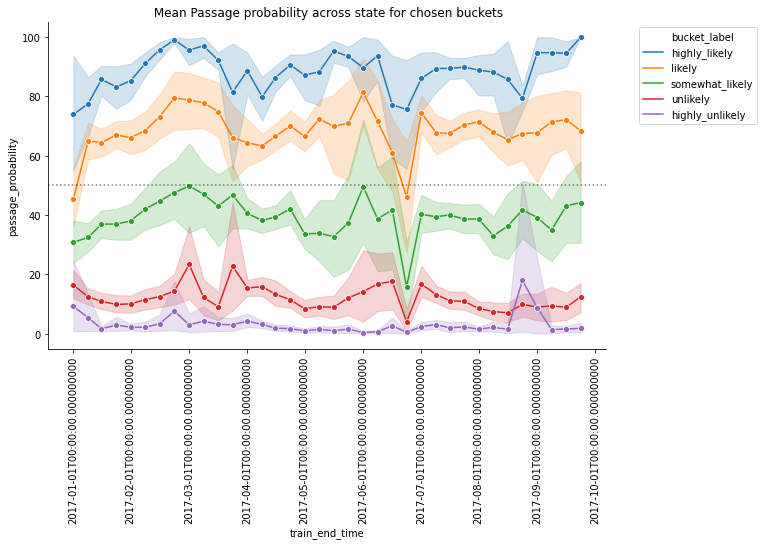

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.lineplot(
    data=state_bucket_probabilities,
    x='train_end_time',
    y='passage_probability',
    hue='bucket_label',
    marker='o',
    ci=95,
    ax=ax
)
g.set_xticklabels(labels=bucket_probabilities['train_end_time'].unique(), rotation=90)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.axhline(y=50, color='k', linestyle=':', alpha=0.5)
# t = ax.set_title(' Mean Passage probability across state for chosen buckets \n (lower limit inclusive) \n \n {} \n'.format(buckets))
t = ax.set_title(' Mean Passage probability across state for chosen buckets')

#### Across time

#### No. States that are present in the test data

In [48]:
q = """
    select 
        c.model_id, 
        count(distinct state) as num_active_states
    from clean.bills a join test_results.predictions c on a.bill_id=c.entity_id
    where model_id in {model_ids}
    group by 1
""".format(
    model_ids=tuple(models['model_id'].tolist())
)

num_states = pd.read_sql(q, db_conn)

In [49]:
num_states = num_states.merge(models, on='model_id')

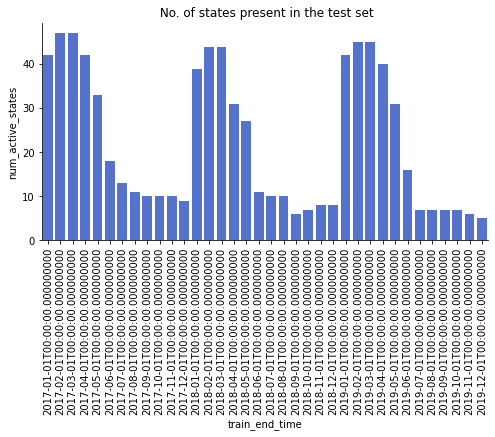

In [50]:
fig, ax = plt.subplots(figsize=(8, 4))

g = sns.barplot(
    data=num_states,
#     hue='num_active_states',
    x='train_end_time',
    y='num_active_states',
    ci='sd',
    ax=ax,
    color='royalblue'
)
g.set_xticklabels(labels=bucket_probabilities['train_end_time'].unique(), rotation=90)
sns.despine()
t = ax.set_title(' No. of states present in the test set')

#### Learning bins [BELOW THIS IS DEPRECATED]

In [253]:
bin_target_probs = {
    'will_not_pass': [0, 0.10],
    'unlikely': [0.10, 0.35],
    'could go either way': [0.35, 0.60],
    'likely': [0.60, 0.90],
    'will_pass': [0.90, 1.1]
}

In [254]:
score_buckets_all = get_passage_prob_model_score_buckets(
    db_conn, model_id, num_buckets=50
)

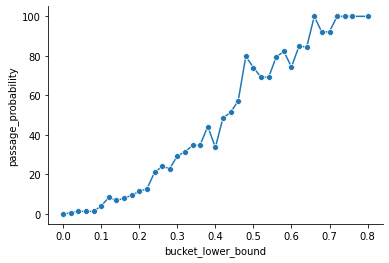

In [255]:
sns.lineplot(data=score_buckets_all, x='bucket_lower_bound', y='passage_probability', marker='o')
sns.despine()

In [256]:
score_buckets_all['model_id'].unique()

array([17836])

In [257]:
def get_score_bands_for_prob_bins(db_conn, model_id, bin_target_probs, num_score_bins=50):

    score_buckets_all = get_passage_prob_model_score_buckets(
        db_conn, model_id, num_buckets=num_score_bins
    )

    score_bounds = dict()
    score_bounds['model_id'] = model_id
    for bin_label, prob_thresholds in bin_target_probs.items():
        lower_lim = prob_thresholds[0]
        upper_lim = prob_thresholds[1]

        msk = (score_buckets_all['passage_probability'] >= lower_lim) & (score_buckets_all['passage_probability'] < upper_lim) 

        lowest_score = score_buckets_all[msk]['bucket_lower_bound'].min()
        highest_score = score_buckets_all[msk]['bucket_lower_bound'].max()

        score_bounds[bin_label + '_lower'] = lowest_score
        score_bounds[bin_label + '_upper'] = highest_score
        
    return score_bounds

In [258]:
bin_target_probs  = {
    'will_not_pass': [0, 15],
    'unlikely': [15, 35],
    'could go either way': [35, 55],
    'likely': [55, 90],
    'will_pass': [90, 101]
}

learned_bins = pd.DataFrame()

for model_id in models['model_id'].tolist():
    d = get_score_bands_for_prob_bins(db_conn, model_id, bin_target_probs, num_score_bins=50)
    learned_bins = learned_bins.append(d, ignore_index=True)

In [259]:
learned_bins = learned_bins.merge(models, on='model_id')

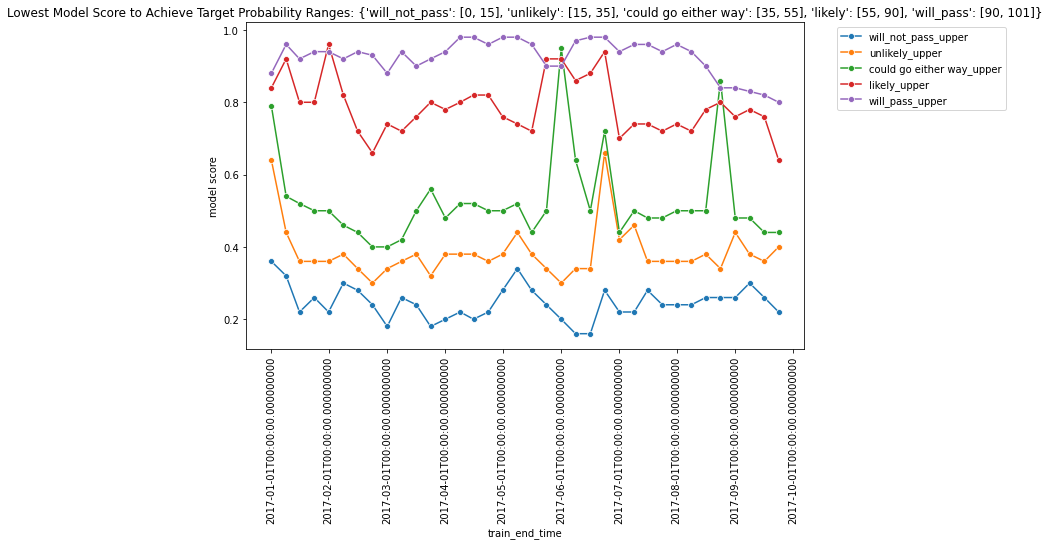

In [260]:
fig, ax = plt.subplots(figsize=(10, 6))

for bin_label in bin_target_probs.keys():
    g = sns.lineplot(data=learned_bins, x='train_end_time', y=bin_label + '_upper', ax=ax, label=bin_label + '_upper', marker='o')
    g.set_xticklabels(labels=learned_bins['train_end_time'].unique(), rotation=90)

ax.set_ylabel('model score')
ax.set_title('Lowest Model Score to Achieve Target Probability Ranges: {}'.format(bin_target_probs))
plt.legend(bbox_to_anchor=(1.05, 1))


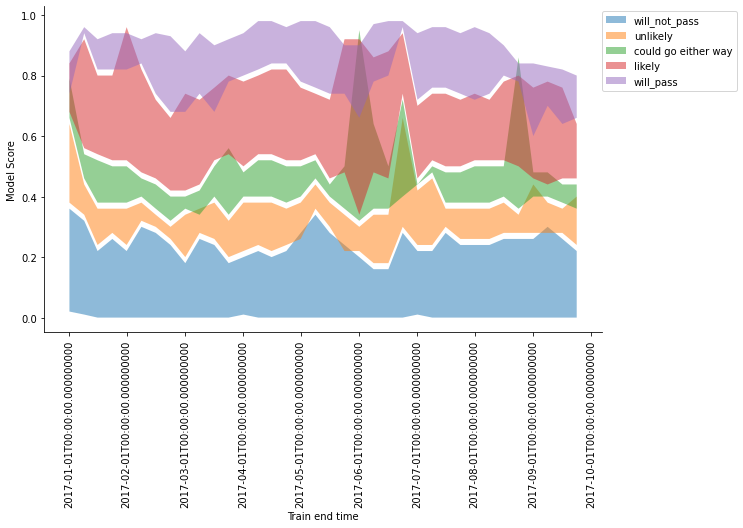

In [261]:
fig, ax = plt.subplots(figsize=(10, 6))

for bin_label in bin_target_probs.keys():
    ax.fill_between(learned_bins['train_end_time'], learned_bins[bin_label + '_upper'], learned_bins[bin_label + '_lower'] , alpha=0.5, label = bin_label)
    ax.set_xticklabels(labels=learned_bins['train_end_time'].unique(), rotation=90)

ax.set_ylabel('Model Score')
ax.set_xlabel('Train end time')
plt.legend(bbox_to_anchor=(1.25, 1))
sns.despine(ax=ax)